In [6]:
# 🚀 Auto-setup: installs deps + configures CFBD access
import os
import sys
from pathlib import Path

# Find _auto_setup.py regardless of current working directory
_current = Path().resolve()
_auto_setup_path = None
for parent in [_current] + list(_current.parents):
    candidate = parent / "model_pack" / "_auto_setup.py"
    if candidate.exists():
        _auto_setup_path = candidate
        # Add project root to sys.path (auto_setup.py will also do this)
        if str(parent) not in sys.path:
            sys.path.insert(0, str(parent))
        break

if _auto_setup_path and _auto_setup_path.exists():
    # Execute the file directly without changing directory
    with open(_auto_setup_path, 'r') as f:
        exec(f.read(), {'__file__': str(_auto_setup_path)})
else:
    # Fallback: try relative path
    try:
        with open("./_auto_setup.py", 'r') as f:
            exec(f.read(), {'__file__': './_auto_setup.py'})
    except FileNotFoundError:
        print("⚠️  Could not find _auto_setup.py. Please run from model_pack directory.")


# Model Stacking: Combining Predictions from Multiple Models

This notebook demonstrates how to ensemble different models (XGBoost, Neural Net, and Logistic Regression) using stacking to improve prediction performance on college football outcomes.

Ensemble methods work by combining the predictions from multiple models to produce a final prediction. The idea is that by leveraging the strengths of different models, we can achieve better performance than any single model alone. This is particularly useful in complex tasks like predicting sports outcomes, where different models may capture different patterns in the data.

There are several ways to combine models in an ensemble, including:

1. **Bagging**: Training multiple instances of the same model on different subsets of the data and averaging their predictions. This helps reduce variance and is the basis for algorithms like Random Forest.

2. **Boosting**: Training models sequentially, where each new model focuses on correcting the errors made by the previous ones. This can lead to improved accuracy but may also increase the risk of overfitting.

3. **Stacking**: Training multiple models (often of different types) and then using their predictions as input features for a final model (meta-model). This allows the meta-model to learn how to best combine the predictions from the base models.

## 1. Load and Prepare Data

Load data, select features, and preprocess the dataset as with previous notebooks.

In [7]:
import pandas as pd
import sys
from pathlib import Path

_config_dir = Path().resolve() / "config"
if str(_config_dir.parent) not in sys.path:
    sys.path.insert(0, str(_config_dir.parent))

from config.data_config import get_data_config

config = get_data_config()
training_data_path = config.get_training_data_path()
df = pd.read_csv(training_data_path)

print("Loaded training dataset for Stacked Ensemble:")
print(f"Source: {training_data_path}")
print(df.shape)
print(df.head(5))

df['home_win'] = (df['home_points'] > df['away_points']).astype(int)

cont_features = [
    'home_adjusted_epa', 'home_adjusted_epa_allowed', 'away_adjusted_epa', 'away_adjusted_epa_allowed',
    'home_talent', 'away_talent', 'home_elo', 'away_elo'
]
cat_features = ['week', 'home_conference', 'away_conference']
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Get dummy column names (only those that exist)
dummy_cols = [col for col in df.columns if any(cat in col for cat in cat_features)]
features = cont_features + dummy_cols

# Filter to only features that exist in the dataframe
features = [f for f in features if f in df.columns]

# Remove rows with missing values in features or target
df_clean = df.dropna(subset=features + ['home_win', 'home_points', 'away_points'])

if len(df_clean) == 0:
    raise ValueError("No rows with complete data. Check for missing values.")

print(f"Using {len(df_clean)} games with complete data (dropped {len(df) - len(df_clean)} rows with missing values)")
print(f"Features: {len(features)} columns")
df_clean[features]

Loaded training dataset for Stacked Ensemble:
Source: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/model_pack/updated_training_data.csv
(6029, 86)
          id           start_date  season season_type  week  neutral_site  \
0  400876038  2016-12-17 19:00:00    2016  postseason     1          True   
1  400876039  2016-12-17 20:30:00    2016  postseason     1          True   
2  400876040  2016-12-17 22:30:00    2016  postseason     1          True   
3  400876041  2016-12-18 02:00:00    2016  postseason     1          True   
4  400876042  2016-12-19 19:30:00    2016  postseason     1          True   

         home_team    home_conference  home_elo  home_talent  ...  \
0             UTSA     Conference USA    1374.0       397.64  ...   
1  San Diego State      Mountain West    1666.0       482.31  ...   
2           Toledo       Mid-American    1662.0       460.86  ...   
3        Louisiana           Sun Belt    1315.0       421.37  ...   
4            Tulsa  American Athlet

,home_adjusted_epa,home_adjusted_epa_allowed,away_adjusted_epa,away_adjusted_epa_allowed,home_talent,away_talent,home_elo,away_elo,week_2,week_3,...,away_conference_MWC,away_conference_Mid-American,away_conference_Mountain West,away_conference_PAC,away_conference_Pac-12,away_conference_Patriot,away_conference_SBC,away_conference_SEC,away_conference_Southern,away_conference_Sun Belt
0,0.139089,0.133384,0.248926,0.248519,397.64,387.26,1374.0,1447.0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.190031,0.091171,0.181700,0.079469,482.31,572.70,1666.0,1836.0,False,False,...,False,False,True,False,False,False,False,False,False,False
2,0.292280,0.185973,0.159179,0.084374,460.86,333.36,1662.0,1628.0,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0.088157,0.120729,0.149916,0.177126,421.37,441.29,1315.0,1399.0,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.208161,0.152647,0.142084,0.150315,409.17,391.81,1650.0,1329.0,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5912,0.080827,-0.127957,0.127957,-0.080827,804.77,770.48,1765.0,1492.0,False,False,...,False,False,False,False,False,False,False,True,False,False
5913,0.088401,0.013297,-0.013297,-0.088401,569.46,493.50,1500.0,1396.0,False,False,...,False,False,False,False,False,False,False,False,False,False
5914,0.091235,-0.149600,0.149600,-0.091235,649.36,745.01,1772.0,1605.0,False,False,...,False,False,False,False,False,False,False,False,False,False
5915,0.051362,0.041509,-0.041509,-0.051362,586.84,489.33,1510.0,1348.0,False,False,...,False,False,True,False,False,False,False,False,False,False


## 2. Train/Test Split

Use `train_test_split` to split the dataset into training and testing sets.

In [8]:
from sklearn.model_selection import train_test_split

# Use cleaned dataframe
X = df_clean[features]
y = df_clean['home_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=77)

print(f"Training set: {len(X_train)} games")
print(f"Test set: {len(X_test)} games")


Training set: 3870 games
Test set: 968 games


## 3. Train Base Models

We will train three base models from previous notebooks: XGBoost, Random Forest, and Logistic Regression. Each model will be trained on the same training data.

Here we define a function to house the configuration for each model and return the models untrained.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_models():
    return [
        make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
        XGBClassifier(eval_metric="logloss", random_state=77),
        RandomForestClassifier(n_estimators=100, random_state=77)
    ]

When you're building a stacked model, you're combining several "base" models (like logistic regression, XGBoost, and random forest) into one stronger model. But to do this the right way, you have to avoid a common mistake: using predictions from models that have already seen the data.

Why? Because that creates data leakage, the final model gets to "peek" at the correct answers during training, which leads to overly confident predictions and poor performance on new data.

To prevent this, we use a technique called **out-of-fold (OOF) predictions**. Here's how it works:

1. **K-Fold Cross-Validation**: We split the training data into K subsets (or folds). For each fold, we train the base models on the K-1 other folds and validate them on the remaining fold. This way, the models never see the validation data during training.

2. **Generate OOF Predictions**: As we validate each model on its fold, we save the predictions for the validation set. These predictions are called out-of-fold predictions because they come from data that was not used during the model's training.

3. **Stacking the Predictions**: Once we have the OOF predictions for all folds and all models, we can use these predictions as features for our meta-model. This means the meta-model is trained on predictions that are truly independent of the training process, reducing the risk of data leakage.

By following this approach, we can build a robust stacked model that leverages the strengths of each base model while avoiding the pitfalls of data leakage.

In [10]:
from sklearn.model_selection import KFold
import numpy as np

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
oof_preds = np.zeros((X_train.shape[0], 3))  # 3 base models

# Pre-allocate for consistency
models = get_models()

for i in range(n_folds):
    train_idx, val_idx = list(kf.split(X_train))[i]
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    fold_models = get_models()
    for j, model in enumerate(fold_models):
        model.fit(X_tr, y_tr)
        oof_preds[val_idx, j] = model.predict_proba(X_val)[:, 1]

## 4. Train Meta-Model (Stacker)

After training our three base models (Logistic Regression, XGBoost, and Random Forest), we want to combine their strengths to make even better predictions. This is where stacking comes in.

**Why use `np.column_stack`?**  
Each base model gives us a prediction (a probability) for every game. We use `np.column_stack` to put these predictions side-by-side into a new table (matrix), where each column is the predictions from one model. So, for each game, we now have three numbers: one from each model.

**How are these predictions used as features?**  
Instead of using the original game statistics as features, we use the predictions from the base models. For the meta-model, each row is a game, and the columns are the predicted probabilities from the three base models. This means the meta-model learns patterns in how the base models make their predictions.

**How is the meta-model trained?**  
We train the meta-model (in this case, another Logistic Regression) on this new table of predictions, using the actual game outcomes as the target. The meta-model learns how to best combine the base models’ predictions to make the final decision.

**Why choose Logistic Regression as the meta-model?**  
Logistic Regression is simple, fast, and works well when combining probabilities. It can learn the best weights to assign to each base model’s prediction, making it a good choice for a meta-model in stacking.

In [11]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression()
meta_model.fit(oof_preds, y_train)

model_log, model_xgb, model_rf = get_models()
model_log.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

pred_log = model_log.predict_proba(X_test)[:, 1]
pred_xgb = model_xgb.predict_proba(X_test)[:, 1]
pred_rf = model_rf.predict_proba(X_test)[:, 1]

stacked_preds_test = np.column_stack([pred_log, pred_xgb, pred_rf])
ensemble_preds = meta_model.predict_proba(stacked_preds_test)[:, 1]


## 5. Evaluate All Models

Previously, we've used accuracy and AUC to evaluate our models. Now, let's also consider Log Loss as a metric for our stacked model, specifically in the context of predicting the win probability of college football games.

1. **Accuracy**: This is the simplest metric. It measures the proportion of correct predictions made by the model out of all predictions. For example, if a model correctly predicts the winner in 80 out of 100 games, its accuracy is 80%. However, accuracy can be misleading, especially in imbalanced datasets where one outcome (like home team wins) is much more common.

2. **AUC (Area Under the Curve)**: AUC is a performance measurement for classification problems at various threshold settings. In the context of football, it tells us how well the model can distinguish between games where the home team wins and games where they lose, across all possible probability thresholds. AUC ranges from 0 to 1, with 1 being a perfect model and 0.5 being a model with no discrimination ability (similar to random guessing). AUC is particularly useful for imbalanced outcomes, such as when home wins are much more frequent.

3. **Log Loss**: Log Loss, or Logistic Loss, measures the performance of a classification model where the prediction input is a probability value between 0 and 1. For football games, this means Log Loss penalizes the model more when it is confident but wrong about a team's win probability. For example, predicting a 95% chance of a home win when the away team actually wins will be penalized much more than a less confident prediction. A lower Log Loss value indicates a better model. Log Loss is useful when we want to understand the uncertainty of our win probability predictions.

To sum it all up, accuracy gives a quick snapshot of model performance while AUC and Log Loss provide deeper insights, especially in complex scenarios like predicting football game outcomes where class imbalance and probability calibration matter.

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

def evaluate(name, true, prob):
    pred = (prob > 0.5).astype(int)
    print(f"{name}:")
    print(f"  Accuracy: {accuracy_score(true, pred):.3f}")
    print(f"  AUC: {roc_auc_score(true, prob):.3f}")
    print(f"  Log Loss: {log_loss(true, prob):.3f}\n")

evaluate("Logistic Regression", y_test, pred_log)
evaluate("XGBoost", y_test, pred_xgb)
evaluate("Random Forest", y_test, pred_rf)
evaluate("Stacked Ensemble", y_test, ensemble_preds)

Logistic Regression:
  Accuracy: 0.711
  AUC: 0.770
  Log Loss: 0.566

XGBoost:
  Accuracy: 0.667
  AUC: 0.736
  Log Loss: 0.661

Random Forest:
  Accuracy: 0.671
  AUC: 0.745
  Log Loss: 0.584

Stacked Ensemble:
  Accuracy: 0.709
  AUC: 0.768
  Log Loss: 0.568



## 7. Model Importance

We use SHAP to analyze feature importance and create a beeswarm plot as in the previous notebook. Only this time, the features are the models themselves and the beeswarm plot shows how each model's predictions contribute to the final outcome.

{"timestamp": "2025-11-25T03:21:57.301073+00:00", "level": "warning", "logger": "py.warnings", "message": "/Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html\n  from .autonotebook import tqdm as notebook_tqdm\n", "service": "script_ohio", "environment": "development", "taskName": "Task-63"}


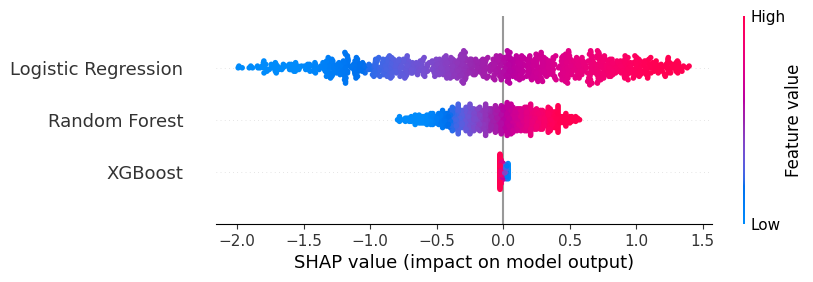

In [13]:
import shap
import pandas as pd

# Define feature names for base model outputs
stacked_feature_names = ["Logistic Regression", "XGBoost", "Random Forest"]

# Use the OOF predictions as training features for SHAP
stacked_train_df = pd.DataFrame(oof_preds, columns=stacked_feature_names)
stacked_test_df = pd.DataFrame(stacked_preds_test, columns=stacked_feature_names)

# Create SHAP explainer for the trained meta-model
explainer = shap.Explainer(meta_model, stacked_train_df)

# Compute SHAP values on test predictions
shap_values = explainer(stacked_test_df)

# Visualize importance of each base model in the ensemble
shap.plots.beeswarm(shap_values)

## 6. Summary

- Stacking combines strengths of multiple models.
- A simple meta-model (logistic) can learn how to weight base predictions.
- Ensembles often generalize better than any single model.
